# 07 - Beyond Confounders

## Good Controls

통제변수가 교란 요인(confounder)인 경우, 모형에 추가하는 것이 좋을 뿐 아니라 필수이다.

무의식적으로 이것을 생각해보면, 측정할 수 있는 모든 것을 모형에 집어 넣는 것이 자연스럽다.

오늘날, 빅데이터 세계에서는 1000개 이상의 변수가 될 수 있다. 하지만 이렇게 많은 변수는 불필요할 뿐만 아니라 인과효과를 식별하는데 도움이 되지 않을 수 있다.

교란 요인이 아닌 통제 변수에 주의를 돌려보자.

먼저, 통제변수의 좋은 점들을 살펴보고, 인과효과를 식별하는데 해로운 통제변수에 대해 알아보자.


예시로 핀테크 데이터 수집팀의 DS라고 가정해보자.

Task는 사람들에게 빛을 갚을 것을 요청하는 이메일을 보내는 행위의 효과를 파악하는 것이다.

반응변수는 연체 고객으로부터의 지불금액(Payments)이다.

이 질문에 답하기 위해선, 데이터 수집팀은 연체고객 중 랜덤하게 5,000명을 선택하여 랜덤 테스트를 실시한다.

그리고 고객의 수만큼 동전을 던진다. 동전이 앞면일 경우, 고객이 이메일을 수신하고, 뒷면이 나올 경우 이메을을 수신하지 않은 통제 그룹으로 남는다.

이 테스트를 통해 이메일이 얼마나 많은 추가 비용을 발생시키는지 알 수 있다.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


데이터가 랜덤이기 때문에 단순한 평균 차이가 ATE(Average Treatment Effect)를 추정한다.

즉, 무작위화 외에는 어떤 것도 treatment의 원인이 될 수 없으므로 잠재적 결과는 treatment와 독립이다. $(Y_0, Y_1) \perp T$

$ATE = E[Y|T = 1] - E[Y|T=0]$

추정량에 대한 신뢰 구간을 계산하기 위해 선형회귀모형을 이용할 수 있다.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


ATE의 추정치는 -0.62로 조금 이상하다.

이메일을 보내는 것이 연체 고객의 평균 지불 금액을 감소시키는 방법인가?

P-value가 너무 높기 때문에 아무런 의미가 없을 수도 있다. 

다른 데이터를 살펴보자. 흥미로운 변수들이 있다.

예를 들어, credit_limit은 연체 전 고객의 신용한도를 나타내고, risk_score는 이메일 보내지 건 고객의 예상 리스크이다.

신용한도와 리스크는 연체고객의 지불금액을 예측하는데 매우 좋은 변수로 보인다. 하지만 이 변수들이 유용할까?

첫째, treatment에 대한 통계적 유의성이 없는 이유를 이해해보자. 이 경우처럼 treatment가 outcome에 거의 영향을 미치지 않을 수 있다.

생각해보면 사람들이 빚을 갚게 하는 것은 대체로 통제변수 이외의 요인일 것이다. 새로운 직장을 구하고, 재정, 수입등을 관리하며 빚을 갚기 때문.

통계적인 관점에서 **지불금액의 변동성은, 메일을 수신하는 것 이외의 다른 요인** 에 의해서도 설명되고 있다고 말할 수 있다.

이를 시각적으로 이해하기 위해 treatment인 이메일에 대한 연체 고객의 지불 금액(payments)를 표시할 수 있다.

회귀모형의 적합값은 빨간색으로 표시했다.(이메일 변수에 약간의 노이즈를 추가하여 0 또는 1에서 값이 겹치지 않도록 시각화함)

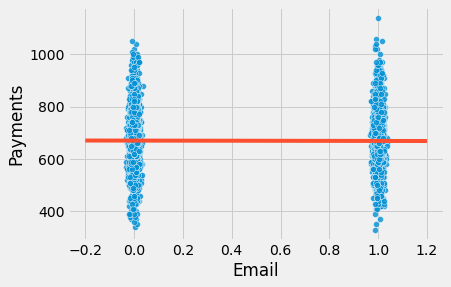

In [4]:
sns.scatterplot("email", "payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");


이제 단일 treatment 그룹에서 지불금액이 얼마나 큰 차이를 보이는지 알 수 있다.

시각적으로 보면 두 그룹 모두 400 ~ 1000 정도이며, 0 대비 1에서 약간 낮아진 경향이 있다.

이메일의 효과가 5.00R 또는 10.00R 정도일 경우, 모든 변동성 안에서 메일의 효과를 찾는 것은 어렵지 않다.

다행히 회귀는 이러한 변동성을 낮추는데 도움을 준다.

트릭은 통제변수를 추가하는 것이다. 

***변수가 outcome의 좋은 예측 변수인 경우, outcome의 분산의 많은 부분을 설명해 준다.***

리스크와 신용한도가 지불금액의 좋은 예측 변수라면 이메일이 지불금액에 미치는 영향을 쉽게 찾을 수 있도록 통제할 수 있다.

회귀가 어떻게 작용하는지 기억한다면, 이것은 직관적인 설명이다.

회귀모형에 변수를 추가하는 것은 treatment를 검토하는 동안 변수를 일정하게 유지하는 것을 의미한다.

따라서, 비슷한 신용한도와 리스크 점수가 나온다면, 반응변수 **payment**의 분산은 더 작아야 한다.

즉, 리스크 점수와 신용한도가 지불금액을 매우 잘 예측한다면, 유사한 리스크 점수와 신용한도를 가진 고객들도 비슷한 지불금액 수준을 가져야하므로 변동이 적은 것이다.

이를 입증하기 위해 두 단계로 회귀를 분해하는 분할 방법을 사용해보자.

우선 treatment(이메일)과 outcome(지불금액)에 대해 추가 통제변수인 신용한도 및 리스크로 회귀한다.

둘째, 1단계에서 얻은 outcome(지불금액)에 대한 잔차에 treatment(이메일)의 잔차를 회귀한다.

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.61241599994
Payments Residual Variance 5652.453558466198
Email Variance 0.24991536000001294
Email Residual Variance 0.24918421069820043


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.427e-14,1.063,6.99e-14,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


다음으로 지불금액의 분산이 어떻게 10807(Payments Variance)에서 5652(Payments Residual Variance)로 변했는지 살펴보자.

리스크와 신용한도를 통제할 경우, 거의 절반으로 분산이 줄었지만, treatment(이메일)의 분산을 줄이지는 못했다.

리스크와 신용한도는 이메일을 전혀 예측하지 못하기 때문에 이 결과는 타당하다(random의 정의상 어떤것도 예측하지 않는다)

이 새로운 추정치에 따르면, 이메일을 수신한 고객이 수신하지 않은 고객보다 평균 4.4 더 지불할 것으로 예상된다.

또한, 각 통제 그룹내에서 분산이 어떻게 더 낮은지 시각화할 수 있다.

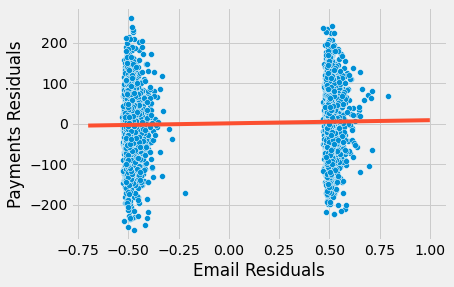

In [7]:
sns.scatterplot("res_email", "res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

실제로 회귀 모형에 treatment와 control 변수를 추가하면 추정치는 정확히 동일하다.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


결론적으로, outcome을 예측하기 위한 좋은 통제변수가 있을 경우, 굳이 교란요인이 아니더라도 모델에 추가하는 것은 좋은 생각일 수 있다.

treatment 효과 추정치의 분산을 낮추는데 도움이 된다.

이 상황을 인과 그래프로 나타내보자.

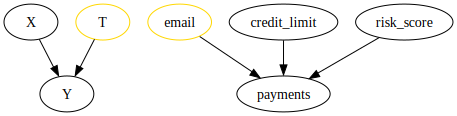

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Mostly Harmful Controls

두 병원의 약물 검사 시나리오를 예시로 들어보자.

두 병원 모두 특정 질병을 치료하기 위해 신약에 대한 무작위 실험을 진행하고 있으며, 반응변수는 입원 일수이다.

치료가 효과적이면 환자의 입원일수가 줄어들 것이다.

한 병원의 경우, 임의로 환자의 90%에게 약을 투여하고 10%에는 위약을 투여한다.

다른 병원의 경우, 임의로 환자의 10%에게 약을 투여하고, 90%에는 위약을 투여한다.

환자에게 90%의 진짜 약물과 10%의 위약을 투여하는 병원이 보통 치료하는데 더 심각한 질병인 경우가 많다.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [15]:
hospital[hospital['hospital']==0].treatment.value_counts()

0    27
1     2
Name: treatment, dtype: int64

In [16]:
hospital[hospital['hospital']==1].treatment.value_counts()

1    48
0     3
Name: treatment, dtype: int64

랜덤화된 데이터를 다루고 있기 떄문에, 첫번째 직관은 단순히 treatment를 outcome에 대해 회귀하는 것이다.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


위의 결과는 직관에 반하는 결과를 얻었다. 어떻게 treatment가 입원 일수를 증가시킬 수 있을까?

중증도는 입원일수 증가와 긍정적으로 연관되며, 중증환자가 많은 병원에서 약물을 더 많이 투여하기 때문에, 약물은 입원일수 증가와 확실히 상관관계가 있다.

두 병원을 함께 살펴보면, $E[Y_0|T=0]<E[Y_0|T=1]$가 있다. 

즉, 중증이 아닌 환자가 있는 병원에 치료를 받지 않은 환자가 더 많기 때문에 치료를 받지 않은 환자의 잠재적 결과는 평균적으로 치료를 받은 그룹의 잠재적 결과보다 낮다.

즉, 중증도는 환자가 가는 병원과 약을 받을 확률을 결정하는 교란 요인으로 작용.

이러한 결과를 수정하는 방법은 두 가지가 있다.
첫째는 두 병원 모두 데이터를 사용하는 목적에 어긋나는 것으로 각 병원별로 ATE를 살펴보는 것이다.

In [17]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [18]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


각 병원별로 나눠 살펴본 결과, 직관적인 ATE를 얻었다.

약은 사실상 병원 입원일수를 줄여주는 것으로 보인다. 다만, 각 병원을 개별적으로 보고 있기 때문에 데이터가 충분치 않다.

따라서 통계적으로 유의한 결과를 찾을 수 없다.

회귀의 힘을 활용하는 다른 접근 방법은 모델에 중증도 변수를 포함하여 통제하는 것이다.(두번째 방법)

In [19]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


이제 다음 질문은 병원 변수도 모형에 포함시켜야 하는가이다.

중증도를 통제하고나면 병원 변수는 더 이상 입원일수와 상관관계가 없다.

교란요인이 되기 위해서는 treatment와 outcome에 모두 원인이 되어야한다.

병원 변수를 포함하여 확인해보자.

In [20]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


중증도 외에 병원을 통제변수로 추가하자 ATE 추정치에 더 많은 편차가 발생하였다. '

어떻게 이런 결과가 나왔을까? 답은 회귀 계수의 표준오차 공식에 있다.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

이 공식에서 표준오차는 X의 분산에 반비례한다는 것을 알 수 있다. 

즉, X가 크게 변하지 않는다면, outcome에 미치는 효과를 추정하기 어렵다. 

극단적으로 약물의 효과를 추정하는 척하고 만 명을 대상으로 검사를 실시하지만, 그 중 한 명만 치료를 받는다고 가정해보자.

이것은 ATE를 찾는 것을 매우 어렵게 만들 것임. 

우리는 한 명의 개인과 다른 모든 사람을 비교하는 것에 의존해야 한다. 

이를 다르게 표현하면 치료의 효과를 쉽게 찾을 수 있도록 치료에 대한 더 많은 다양성이 필요하다는 것이다.

즉, 모형에 병원 변수를 추가하면 추정량의 오차가 증가하는 이유는 treatment에는 좋은 예측변수이지만 outcome에는 좋은 예측변수가 아니기 때문(중증도를 통제할 경우). 

따라서 treatment를 예측함으로써 분산을 낮추는 효과를 가질 수 있다! 

위의 회귀모형을 두 단계로 분해하여 확인해보자.


In [21]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.673e-14,0.827,2.02e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [22]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.05752909187211909


In [23]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.446973767486902


위의 SE(Standard Error) 수식이 참임을 확인할 수 있다.


따라서, 결론은 위의 모델의 중증도 변수와 같이 treatment 및 outcome(혼란 요인)과 관련된 통제변수를 추가해야한다는 것이다.

또한, 교란요인이 아니더라도 outcome에 좋은 예측변수가 되는 통제변수를 추가해야한다.
그 이유는 이러ㅏㄴ 통제변수는 추정치의 분산을 낮추기 때문이다.

그러나, treatment에 좋은 예측변수인 통제변수는 추정량의 분산을 증가시키므로 추가해서는 안된다.

이 상황을 인과관계 그래프로 표현해보자.

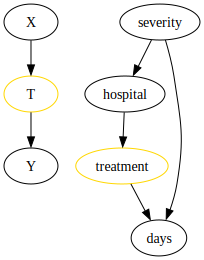

In [24]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

# Bad Contorols - Selection Bias

이메일 예시를 다시 봐보자. 이메일은 무작위로 고객에게 할당되었었다.

앞서 ***credit_limit, risk_score***가 무엇인지 알아보았다.

이제 남은 변수를 살펴보자.

***opened***는 이메일을 열었는지를 나타내는 더미 변수이다.
***agreement***는 이메일을 수신한 후에 관련 부서에 연락하여 채무협상을 한 경우를 나타내는 더미변수이다.

1. treatment(email) + credit_limit + risk_score
2. treatment(email) + credit_limit + risk_score + opened + agreement

위 2가지 모델 중 어떤 모델이 더 적절한지 살펴보자

In [25]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [26]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


1번 모델에서 이메일 변수는 통계적으로 유의해보이고, 2번 모델에서는 그렇지 않다.

하지만, 실제로는 2번 모델이 옳은 모델일 수도 있고, treatment(이메일)은 outcome(지불금액)에 효과가 없을 수도 있다.

앞서, treatment와 outcome에 모두 원인이 되는 교란 요인을 변수로 추가해야한다는 것을 알아보았다.
또한, outcome을 매우 잘 예측하는 통제변수를 추가하는 것도 좋은 아이디어라는 것을 알고 있다.
또한, treatment만을 예측하는 통제변수를 추가하는 것은 좋지 않은 생각이라는 것을 알고 있다.(이것은 치명적인 것은 아니지만 피하는 것이 좋다)

그럼 ***opened, agreement***는 어떤 종류의 통제변수일까? 이 변수는 위에서 설명한 것들에 해당하지 않는다.

직관적으로 생각해보면 ***opened, agreement***는 이메일과 확실히 관계가 있다.
하지만, 이메일을 받지 못한 경우에는 이메일을 열 수가 없다. 또한, ***agreement***도 이메일을 수신한 후에 연락한 경우만 고려한다고 했다. 
그렇기 때문에 이 변수들은 이메일 변수의 원인은 아니다. 대신 이메일 변수가 이 변수들의 원인이 된다.

인과그래프를 통해 변수들을 이해해보자.

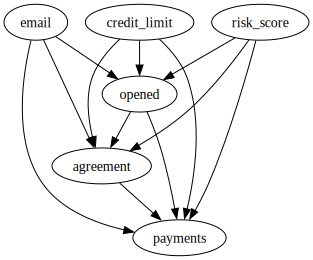

In [27]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

이메일은 랜덤으로 설계되어 있기 때문에 원인이 되는 것은 아무것도 없다.

payments에 대해 생각해보면, 다음과 같은 퍼널의 결과를 생각할 수 있다.

email -> opened -> agreement -> payment

또한, 다른 수준의 리스크를 가진 경우 agreement를 수행하는 성향이 다를 것으로 생각되기 때문에 리스크를 agreement의 원인으로 표시했다.

이메일과 agreement에 관해서, 어떤 사람들은 이메일의 제목을 읽기만 하면 agreement할 가능성이 높아진다고 주장할 수 있다. 요점은 이메일을 열지 않고, agreement를 유발할 수도 있다는 것이다.

이 그래프에 알 수 있는 것은 이메일에서 지불금액까지의 인과경로에 opened와 agreement가 모두 있다는 것이다.

따라서 회귀모형으로 이것들을 통제한다면 ***opened*** 및 ***agreement***가 고정되었을 때의 이메일의 효과라고 말할 것이다. 그러나 둘 다 이메일의 인과 효과의 일부분이기 때문에 고정하고 싶지 않다. ㄷ신, 이메일은 agreement의 비율을 높이기 때문에 정확하게 지불금액을 증가시킨다고 주장할 수 있다.

이러한 변수를 고정하면 이메일의 실제 효과 중 일부가 제거될 수 있다.

잠재적 결과 표기법에서는 무작위화로 인해 $E[Y_0|T=0] = E[Y_0|T=1]$라고 표기할 수 있다.



그러나, 무작위화를 사용하더라도 agreement를 통제할 경우, treatment와 control을 더 이상 비교할 수 없다.

하지만 직관적인 사고를 통해 이것들이 어떻게 다른지 추측할 수 있다.

1. $E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]$

2. $E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]$



1번 식은 이메일(빚을 갚을 것을 요청하는 이메일을 수신했는지 유무)와 agreement(이메일을 수신한 후, 관련 부서에 연락하여 채무협상을 한 경우)가 없는 사람이 이메일이 있고 agreement가 없는 사람보다 payment가 크다라는 것을 나타낸 식이다. 

treatment가 긍정적인 효과가 있다면, 이메일을 받고도 agreement가 없는 사람은 agreement가 없고 이메일도 받지 못한 사람에 비해 지불 측면에서 더 나쁠 것이다.

2번 식은 이메일이 없고, agreement가 있는 사람이 이메일이 있고 agreement도 있는 사람에 비해 더 나을 수도 있다는 식이다.

교란요인은 공통 원인에 대한 통제 실패에서 오는 편향이지만, 선택 편향은 원인에서 효과까지의 경로 사이에 있는 공통 효과 또는 변수에 대해 통제할 때 발생한다.

저자의 경험적으로, 항상 모형에 Y를 잘 예측할 수 있는 변수 혹은 교란 요인을 항상 포함시켜야 한다.

Treatment만을 잘 예측하는 변수 혹은 treatment와 outcome 사이의 매개변수 또는 treatment와 outcom의 공통 효과인 변수는 항상 제외할 것.




![img](./data/img/beyond-conf/selection.png)

선택 편향은 너무 만연해서 랜덤화조차 해결할 수 없다.

선택 편향을 발견하고 피하려면 많은 연습이 필요하다.

아래는 선택 편향의 몇 가지 예시이다.


    1. Adding a dummy for paying the entire debt when trying to estimate the effect of a collections strategy on payments.
    2. Controlling for white vs blue collar jobs when trying to estimate the effect of schooling on earnings
    3. Controlling for conversion when estimating the impact of interest rates on loan duration
    4. Controlling for marital happiness when estimating the impact of children on extramarital affairs
    5. Breaking up payments modeling E[Payments] into one binary model that predict if payment will happen and another model that predict how much payment will happen given that some will: E[Payments|Payments>0]*P(Payments>0)



# Bad COP

예측하려는 연속형 변수가 있지만 분포가 0이 많은 상황이라고 생각해보자.

예를 들어, 고객의 지출 분포를 모형화하려면 감마 분포와 비슷하지만 0이 많다.

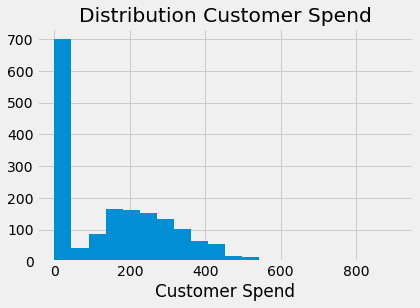

In [28]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

데이터과학자 입장에서 이것을 처음보았을 때 떠오르는 첫번째 생각은 모델링을 두 단계로 나누는 것이다.

첫째는 참여, 즉 $Y > 0$ 일 확률이다. 위 데이터의 예시에서 이것은 고객의 지출 여부를 결정하는 모델이다.

두번째는 참여하기로 결정한 사람들을 위해 $Y$를 모델링한다. 이것은 Conditional-on-Positives 효과이다. 이 경우에 고객이 지출하기로 결정한 후의 지출 금액이다. 지출에 대한 T의 효과를 추정하고자 한다면 다음과 같이 정리할 수 있다.

$E[Y|T] = E[Y|Y>0, T]P(Y>0|T)$

참여모델 $P(Y_i > 0|T_i)$ 에는 아무 문제가 없다. T가 랜덤하게 할당되면 treatment로 인한 지출 확률 증가를 포착할 수 있다.

문제는 COP part를 추정하는 것에 있다. 무작위로 할당되더라도 편향될 수 있다.

직관적인 수준에서 일부 단위는 treatment를 받지 않았기 때문에 0이라고 생각하는 것은 이상한 것이 아니다. treatment로 인해 0이 되지 않는다. 반면에 일부 유닛은 절대로 0이 아니다.
treatment는 outcome을 높일 수 있지만, treatment가 없더라도 그것들은 0이 되지 않는다.

여기서 중요한 것은 이 2가지 유형의 유닛은 비교할 수 없다는 것을 이해하는 것이다.

0이 아닌 사람들은 treatment를 받지 않으면 0인 사람들에 비해 $Y_0$이 높다.

사실, 후자의 경우 $Y_0=0$이다.

이 점에 유의하여 0을 제거하면 treatment 그룹과 통제그룹 양쪽에 0이 유지된다. 하지만, 여기서 treatment를 통해 0에서 0이 아닌 것으로 바뀌는 것들을 통제그룹에서 제거할 것이다.

이것은 treatment와 대조군을 더 이상 비교할 수 없게 만들 것이다. 그 이유는 통제그룹에는 0이 없고, $Y_0$에 높은 값만 포함되는 반면 treatment를 받은 값에는 두 가지 유형의 단위가 모두 포함되기 때문이다.







문제를 직관적으로 이해했으니, 수학적으로 확인해보자. 
이를 위해 treatment 효과를 나눠보자. 랜덤 할당에서는 평균의 차이와 같다.

$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$


마지막 식은 $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ 를 더하고 빼서 재배열 하는 것이다. 

이것은 평균의 차이가 두 부분으로 구성된다는 것을 의미한다. 

첫 째, 결과 $y$가 양수일 확률의 차이다. 이것은 고객이 지출에 참여할 확률의 증가를 측정하기 때문에 참여 효과라고 불리운다. 

둘째, 참여에 따라 결정되는 outcome의 차이인 COP 효과이다. 

여기까지 별다른 문제는 없으나, 문제는 우리가 각 부분을 개별적으로 추정하려고 할 때 발생합니다. 

이것은 COP 효과를 분석하면 더욱 분명해진다.


$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$


$E[Y_{i0}|Y_{i1}>0]$를 더하고 뺀 후에 두 번째 식이 나온다. 

COP 효과를 분해할 때 먼저 참가자 하위 모집단에 대한 인과효과를 얻는다. 

위 예시에서, 이것은 무언가를 소비하기로 결정한 사람들의 인과효과가 될 것이다. 

둘 째, treatment에 할당되었을 때 참여하기로 결정한 사람들($E[Y_{i0}|Y_{i1}>0]$)과 treatment 없이도 참여한 사람들($E[Y_{i0}|Y_{i0}>0]$)에 대한 $Y_0$의 차이인 편향 항을 얻는다. 

우리의 경우,이 편향은 아마도 부정적일 것입니다. 왜냐하면 treatment에 할당되었을 때 treatment를 받지 않은 사람들은 treatment $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$ 가 없어도 지출하는 사람들보다 적을 것이기 때문이다.


COP 편향이 처음에는 매우 직관적이지 않다는 것을 알고 있기 때문에, 시각적인 예를 통해 살펴보자.

마케팅 캠페인을 통해 사람들이 우리 제품에 얼마나 많은 비용을 지출하는지 추정하고자 한다.

이번 마케팅 캠페인은 무작위로 선정되었으므로 교란요인을 걱정할 필요가 없다.

이 예시에서는, 고객을 2개의 segment로 나눌 수 있다. 

1. 마케팅 캠페인을 봐야만 제품을 살 수 있는 사람들이 있다.(여기서 알뜰고객 이라고 부르자)
2. 마케팅 캠페인이 없어도 제품을 소비하는 고객.(여기서 부자고객 이라고 부르자)



![img](./data/img/beyond-conf/cop-ex1.png)
 

앞서 캠페인에 대한 ATE를 추정하기 위해 무작위화를 진행했다.그렇기 때문에 treatment를 받은 것과 받지 않은 것에 대해 비교하기만 하면 된다. 

그러나 추정을 두 가지 모델 $P(Y_i > 0 | T_i)$를 추정하는 참여 모델과 $E[Y_i|Y_i>0]$을 추정하는 COP로 나누는 COP 공식을 사용한다고 가정하면 지출하지 않은 모든 사람이 분석에서 제거된다.

![img](./data/img/beyond-conf/cop-ex2.png)
 

이 경우, treatment그룹과 통제 그룹은 더 이상 비교할 수 없다.

treatment를 받지 않은 사람들은 이제 캠페인 없이도 소비할 고객 일부만 구성되어 있다.

또한, 여기서 편향의 방향을 알 수 있다.

$E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ 혹은 $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$ 일 것이다.

부자고객이 알뜰고객보다 더 많은 돈을 쓰기 때문에 이는 분명히 부정적이다.

결과적으로 참가자 모집단만 필터링하면 무작위화로 인해 처음에는 편향이 없더라도, ATE에 대한 추정치가 편향되게 된다.

선택 편향을 마무리하기 위해, 항상 treatment와 outcome 사이에 있거나, outcome과 treatment의 공통적인 효과인 변수를 통제하지 말아야한다는 것을 상기시킬 필요가 있다.

그래프를 통해 잘못된 통제 예시를 살펴보자.

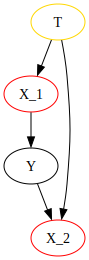

In [30]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g